In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization


In [2]:
def discretized_function(x, y):
    y = np.round(y)
    return (-1*np.cos(x) + -1*np.cos(y))/((x/3)**2 + (y/3)**2 + 1)

In [3]:
# Bounded region of parameter space
c_pbounds = {'x': (-5, 5), 'y': (-5, 5)}

In [4]:
labels = ["All-float Optimizer", "Typed Optimizer"]

In [5]:
continuous_optimizer = BayesianOptimization(
    f=discretized_function,
    pbounds=c_pbounds,
    verbose=2,
    random_state=1,
)


d_pbounds = {'x': (-5, 5), 'y': (-5, 5, int)}
discrete_optimizer = BayesianOptimization(
    f=discretized_function,
    pbounds=d_pbounds,
    verbose=2,
    random_state=1,
)

In [6]:
for lbl, optimizer in zip(labels, [continuous_optimizer, discrete_optimizer]):
    print(f"====================  {lbl}  ====================\n")
    optimizer.maximize(
        init_points=2,
        n_iter=8
    )
    print(f"Max: {optimizer.max['target']}\n\n")

====================  All-float Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.1702   | -0.829779 | 2.2032449 |
| 2         | 0.03165   | -4.998856 | -1.976674 |
| 3         | 0.04415   | -4.946870 | -2.137915 |
| 4         | -0.002676 | -4.441393 | -4.515654 |
| 5         | 0.6544    | -3.051440 | -2.571351 |
| 6         | 0.4494    | -2.023482 | -2.342706 |
| 7         | 0.4207    | -2.516753 | -3.549863 |
| 8         | 0.2129    | -3.015779 | -1.270144 |
| 9         | -0.1227   | -0.103683 | -3.639513 |
| 10        | -0.06719  | 4.8593667 | 4.9971018 |
Max: 0.6544320709931273


====================  Typed Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.1702   | -0.829779 | 2         |
| 2         | 0.03165   | -4.998856 | -2        |
| 3         | 0.08123   | -4.803093 | -2        

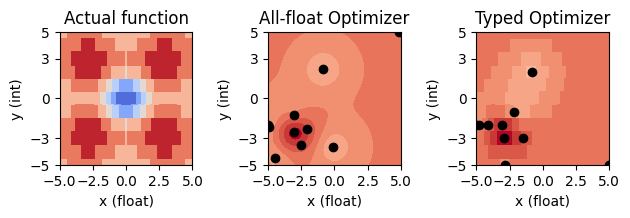

In [7]:
x = np.linspace(c_pbounds['x'][0], c_pbounds['x'][1], 1000)
y = np.linspace(c_pbounds['y'][0], c_pbounds['y'][1], 1000)

X, Y = np.meshgrid(x, y)

Z = discretized_function(X, Y)

params = [{'x': x_i, 'y': y_j} for y_j in y for x_i in x]
array_params = [continuous_optimizer._space.params_to_array(p) for p in params]
c_pred = continuous_optimizer._gp.predict(array_params).reshape(X.shape)
d_pred = discrete_optimizer._gp.predict(array_params).reshape(X.shape)

vmin = np.min([np.min(Z), np.min(c_pred), np.min(d_pred)])
vmax = np.max([np.max(Z), np.max(c_pred), np.max(d_pred)])

fig, axs = plt.subplots(1, 3)

axs[0].set_title('Actual function')
axs[0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)


axs[1].set_title(labels[0])
axs[1].contourf(X, Y, c_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[1].scatter(continuous_optimizer._space.params[:,0], continuous_optimizer._space.params[:,1], c='k')

axs[2].set_title(labels[1])
axs[2].contourf(X, Y, d_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[2].scatter(discrete_optimizer._space.params[:,0], discrete_optimizer._space.params[:,1], c='k')


def make_plot_fancy(ax: plt.Axes):
    ax.set_aspect("equal")
    ax.set_xlabel('x (float)')
    ax.set_xticks([-5.0, -2.5, 0., 2.5, 5.0])
    ax.set_ylabel('y (int)')
    ax.set_yticks([-5, -3, 0, 3, 5])

for ax in axs:
    make_plot_fancy(ax)

plt.tight_layout()
plt.show()

## 3. Categorical variables


In [8]:
def f1(x1, x2):
    return -1*(x1 - np.sqrt(x1**2 + x2**2) * np.cos(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def f2(x1, x2):
    return -1*(x2 - np.sqrt(x1**2 + x2**2) * np.sin(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def SPIRAL(x1, x2, k):
    """cf Ladislav-Luksan
    """
    if k=='1':
        return f1(x1, x2)
    elif k=='2':
        return f2(x1, x2)


In [9]:
pbounds = {'x1': (-10, 10), 'x2': (-10, 10), 'k': ('1', '2')}

categorical_optimizer = BayesianOptimization(
    f=SPIRAL,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

categorical_optimizer.maximize(
        init_points=2,
        n_iter=18,
    )

|   iter    |  target   |     k     |    x1     |    x2     |
-------------------------------------------------------------
| 1         | 8.698     |     2     | -9.997712 | -3.953348 |
| 2         | 6.796     |     1     | -6.274795 | -3.088785 |
| 3         | 7.978     |     2     | -9.970416 | -3.781190 |
| 4         | 4.331     |     1     | -9.784631 | -5.210773 |
| 5         | -14.69    |     1     | 9.1818929 | 6.0937003 |
| 6         | 0.5244    |     2     | -9.947053 | 4.9142403 |
| 7         | 17.04     |     2     | 9.9626887 | -9.994737 |
| 8         | -10.26    |     1     | 4.8389550 | -9.994760 |
| 9         | 2.323     |     2     | 9.9704528 | -7.076212 |
| 10        | 13.23     |     1     | -9.169301 | -0.486971 |
| 11        | -3.706    |     2     | -5.889131 | 1.1635320 |
| 12        | 12.81     |     2     | 9.1816596 | -9.986873 |
| 13        | 2.761     |     1     | -1.480697 | 9.9724447 |
| 14        | 15.44     |     2     | -4.812190 | -9.939661 |
| 15    

In [10]:
res = categorical_optimizer._space.res()
k1 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='1'])
k2 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='2'])

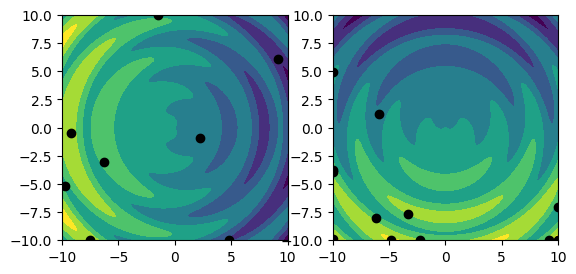

In [11]:
x1 = np.linspace(pbounds['x1'][0], pbounds['x1'][1], 1000)
x2 = np.linspace(pbounds['x2'][0], pbounds['x2'][1], 1000)

X1, X2 = np.meshgrid(x1, x2)
Z1 = SPIRAL(X1, X2, '1')
Z2 = SPIRAL(X1, X2, '2')

fig, axs = plt.subplots(1, 2)

vmin = np.min([np.min(Z1), np.min(Z2)])
vmax = np.max([np.max(Z1), np.max(Z2)])

axs[0].contourf(X1, X2, Z1, vmin=vmin, vmax=vmax)
axs[0].set_aspect("equal")
axs[0].scatter(k1[:,0], k1[:,1], c='k')
axs[1].contourf(X1, X2, Z2, vmin=vmin, vmax=vmax)
axs[1].scatter(k2[:,0], k2[:,1], c='k')
axs[1].set_aspect("equal")


## 4. Use in ML

In [12]:
from sklearn.datasets import load_diabetes
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from bayes_opt import BayesianOptimization

data = load_diabetes()

kernels = ['rbf', 'poly']

def f_target(kernel, C, degree):
    
    model = SVC(C=C, kernel=kernel, degree=degree)
    model.fit(data['data'], data['target'])

    weighted_f1 = f1_score(model.predict(data['data']), data['target'], average='weighted')
    return weighted_f1


params_svm ={
    'kernel': ['rbf', 'poly'],
    'C':(1e-1, 1e+1),
    'degree':(1, 3, int),
}

optimizer = BayesianOptimization(f_target, params_svm, random_state=42, verbose=2)

optimizer.maximize(init_points=2, n_iter=10)

|   iter    |  target   |     C     |  degree   |  kernel   |
-------------------------------------------------------------
| 1         | 0.8166    | 3.8079471 | 3         |    rbf    |
| 2         | 0.1887    | 1.6445845 | 1         |   poly    |
| 3         | 0.6176    | 3.8018183 | 3         |   poly    |
| 4         | 0.6639    | 4.9294903 | 3         |   poly    |
| 5         | 0.9169    | 5.7324339 | 1         |    rbf    |
| 6         | 0.9536    | 7.0665290 | 1         |    rbf    |
| 7         | 0.9827    | 9.6695859 | 1         |    rbf    |
| 8         | 0.9807    | 9.3918632 | 3         |    rbf    |
| 9         | 0.9706    | 7.8178252 | 3         |    rbf    |
| 10        | 0.9749    | 8.5973444 | 2         |    rbf    |
| 11        | 0.8493    | 9.9999466 | 2         |   poly    |
| 12        | 0.9749    | 8.5770975 | 1         |    rbf    |
